In [1]:
# import modules
import pandas as pd
import numpy as np
import torch
import tensorflow
import matplotlib.pyplot as plt
import pickle
from utils import masked_aCC, masked_mse, one_hot
from WL_GNN_model.MolecularGNN_smiles_train import MolecularGraphNeuralNetwork

2023-05-12 09:14:25.191006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:14:26.546494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546576: W 

0.45702982682911264
0.4287184350555252
0.447069060249793
0.3396527565103711
0.46567401685160215
0.435930226492963
0.4596413452878846
0.35030629299842536


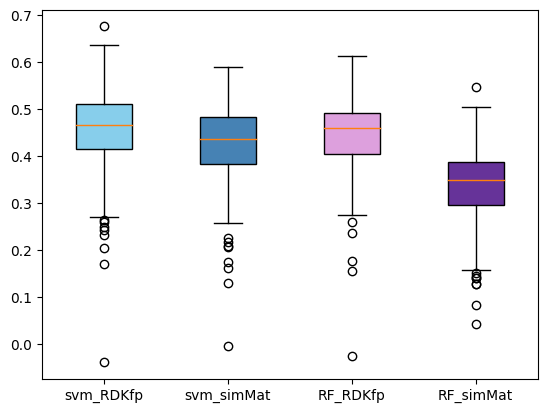

0.0208643348639364
0.020874292577652064
0.020432994398106346
0.02285811863016486
0.020809353718701545
0.020719389602840164
0.02022349192146726
0.022793975567202897


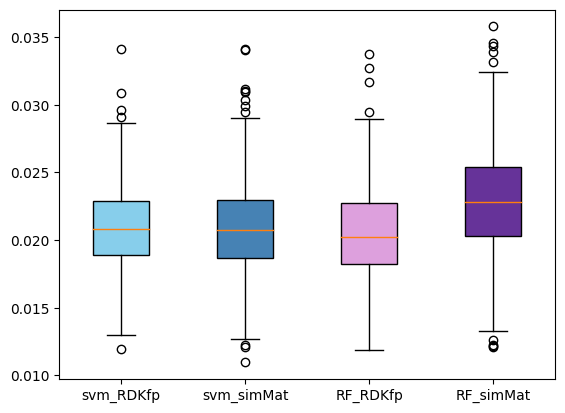

0.23728702976483085
0.22289729169159556
0.2460842405336061
0.250721125485878
0.21259270415203635
0.17972770839805638
0.21540513561347846
0.23030950334285277


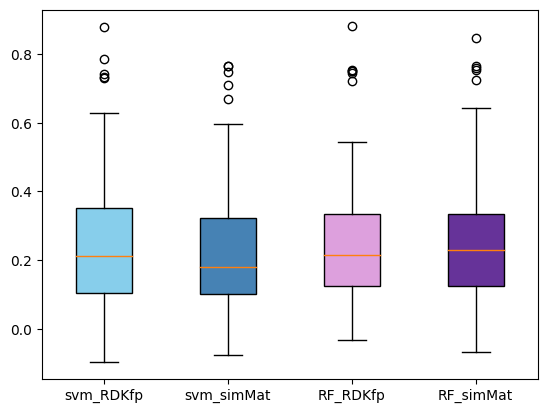

0.021397132887495025
0.021453498626994725
0.02092915155174738
0.023309957840291377
0.0123262894829412
0.009923841906032169
0.011789202005457373
0.009504333782448006


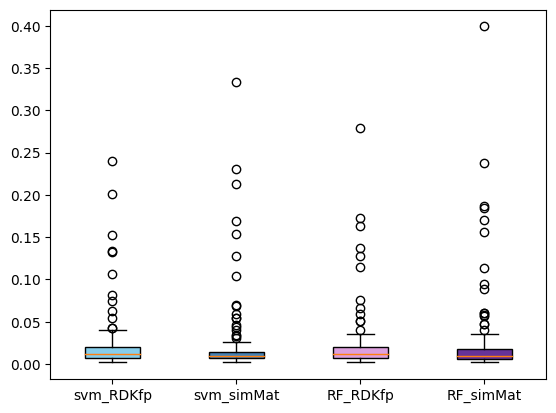

In [4]:
#1-1. ML models comparison
## import prediction and ground truth
train_set = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col="smiles")
test_set = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_drugBlind_test.csv", index_col="smiles")
svm_RDKfp_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/svm_RDKfp_DrugBlind_pred.csv", index_col = 'drug')
RF_RDKfp_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/RF_RDKfp_DrugBlind_pred.csv", index_col = 'drug')
svm_simMat_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/svm_simMat_DrugBlind_pred.csv", index_col = 'drug')
RF_simMat_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/RF_simMat_DrugBlind_pred.csv", index_col = 'drug')

mask = np.matrix(np.isnan(test_set)==False, dtype=int)
label = np.matrix(test_set)
pred_svm_RDKfp = np.matrix(svm_RDKfp_pred)
pred_RF_RDKfp = np.matrix(RF_RDKfp_pred)
pred_svm_simMat = np.matrix(svm_simMat_pred)
pred_RF_simMat = np.matrix(RF_simMat_pred)

## evaluation
### cell-wise
svm_RDKfp_pcc = masked_aCC(pred_svm_RDKfp.T, label.T, mask.T)
RF_RDKfp_pcc = masked_aCC(pred_RF_RDKfp.T, label.T, mask.T)
svm_simMat_pcc = masked_aCC(pred_svm_simMat.T, label.T, mask.T)
RF_simMat_pcc = masked_aCC(pred_RF_simMat.T, label.T, mask.T)

svm_RDKfp_mse = masked_mse(pred_svm_RDKfp.T, label.T, mask.T)
RF_RDKfp_mse = masked_mse(pred_RF_RDKfp.T, label.T, mask.T)
svm_simMat_mse = masked_mse(pred_svm_simMat.T, label.T, mask.T)
RF_simMat_mse = masked_mse(pred_RF_simMat.T, label.T, mask.T)

### visualization
colors_dict = {"RF_simMat": "rebeccapurple", 'RF_RDKfp':'plum',
               "svm_simMat": "steelblue", "svm_RDKfp": "skyblue"}
#### cell line-wise pcc
print(np.mean(np.array(svm_RDKfp_pcc).flatten()))
print(np.mean(np.array(svm_simMat_pcc).flatten()))
print(np.mean(np.array(RF_RDKfp_pcc).flatten()))
print(np.mean(np.array(RF_simMat_pcc).flatten()))
print(np.median(np.array(svm_RDKfp_pcc).flatten()))
print(np.median(np.array(svm_simMat_pcc).flatten()))
print(np.median(np.array(RF_RDKfp_pcc).flatten()))
print(np.median(np.array(RF_simMat_pcc).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_pcc).flatten(),
            'svm_simMat': np.array(svm_simMat_pcc).flatten(),
            'RF_RDKfp': np.array(RF_RDKfp_pcc).flatten(),
            'RF_simMat': np.array(RF_simMat_pcc).flatten()
            }

fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()
#### cell line-wise mse
print(np.mean(np.array(svm_RDKfp_mse).flatten()))
print(np.mean(np.array(svm_simMat_mse).flatten()))
print(np.mean(np.array(RF_RDKfp_mse).flatten()))
print(np.mean(np.array(RF_simMat_mse).flatten()))
print(np.median(np.array(svm_RDKfp_mse).flatten()))
print(np.median(np.array(svm_simMat_mse).flatten()))
print(np.median(np.array(RF_RDKfp_mse).flatten()))
print(np.median(np.array(RF_simMat_mse).flatten()))


pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_mse).flatten(),
            'svm_simMat': np.array(svm_simMat_mse).flatten(),
            'RF_RDKfp': np.array(RF_RDKfp_mse).flatten(),
             'RF_simMat': np.array(RF_simMat_mse).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

### drug-wise
svm_RDKfp_pcc = masked_aCC(pred_svm_RDKfp, label, mask)
RF_RDKfp_pcc = masked_aCC(pred_RF_RDKfp, label, mask)
svm_simMat_pcc = masked_aCC(pred_svm_simMat, label, mask)
RF_simMat_pcc = masked_aCC(pred_RF_simMat, label, mask)

svm_RDKfp_mse = masked_mse(pred_svm_RDKfp, label, mask)
RF_RDKfp_mse = masked_mse(pred_RF_RDKfp, label, mask)
svm_simMat_mse = masked_mse(pred_svm_simMat, label, mask)
RF_simMat_mse = masked_mse(pred_RF_simMat, label, mask)

### visualization

#### drug-wise pcc
print(np.mean(np.array(svm_RDKfp_pcc).flatten()))
print(np.mean(np.array(svm_simMat_pcc).flatten()))
print(np.mean(np.array(RF_RDKfp_pcc).flatten()))
print(np.mean(np.array(RF_simMat_pcc).flatten()))
print(np.median(np.array(svm_RDKfp_pcc).flatten()))
print(np.median(np.array(svm_simMat_pcc).flatten()))
print(np.median(np.array(RF_RDKfp_pcc).flatten()))
print(np.median(np.array(RF_simMat_pcc).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_pcc).flatten(),
             'svm_simMat': np.array(svm_simMat_pcc).flatten(),
             'RF_RDKfp': np.array(RF_RDKfp_pcc).flatten(),
            'RF_simMat': np.array(RF_simMat_pcc).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()


#### drug-wise mse
print(np.mean(np.array(svm_RDKfp_mse).flatten()))
print(np.mean(np.array(svm_simMat_mse).flatten()))
print(np.mean(np.array(RF_RDKfp_mse).flatten()))
print(np.mean(np.array(RF_simMat_mse).flatten()))
print(np.median(np.array(svm_RDKfp_mse).flatten()))
print(np.median(np.array(svm_simMat_mse).flatten()))
print(np.median(np.array(RF_RDKfp_mse).flatten()))
print(np.median(np.array(RF_simMat_mse).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_mse).flatten(),
            'svm_simMat': np.array(svm_simMat_mse).flatten(),
            'RF_RDKfp': np.array(RF_RDKfp_mse).flatten(),
            'RF_simMat': np.array(RF_simMat_mse).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

0.45702982682911264
0.39989440477364324
0.33922692603817944
0.24936122486241183
0.46567401685160215
0.4041205502004209
0.344356742762817
0.2694418163402113


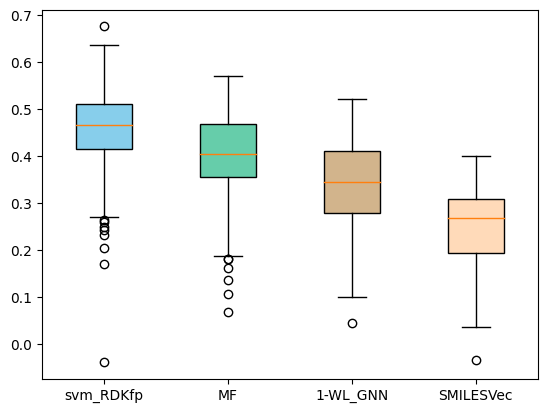

0.0208643348639364
0.022550304231105937
0.027666493073591567
0.031422455327545756
0.020809353718701545
0.022549657098918215
0.02774954534663581
0.031743745292129893


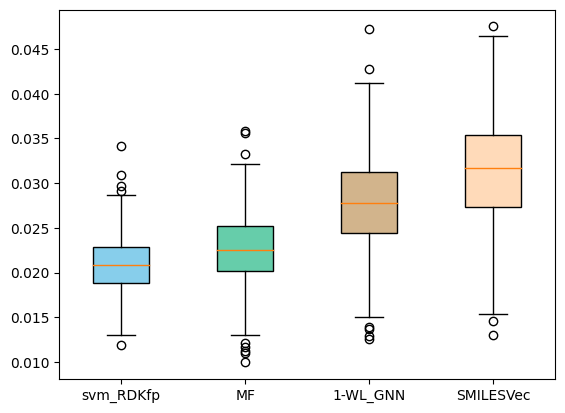

0.23728702976483085
0.24774961432116646
0.24584659814186546
0.22921443481650725
0.21259270415203635
0.23518431785943683
0.23385345358553977
0.22327533940819294


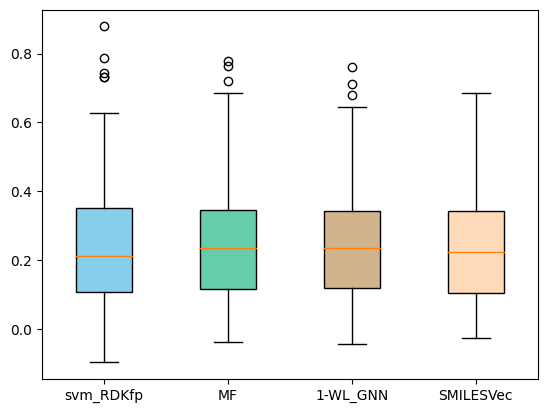

0.021397132887495025
0.02298011796832143
0.027656847940972187
0.031783167179348225
0.0123262894829412
0.007397570611249493
0.010847613779359788
0.010447030649566983


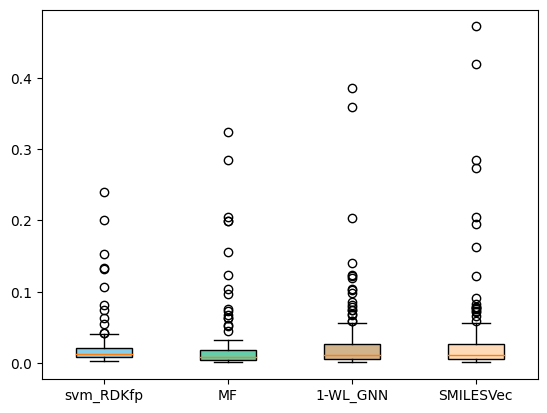

In [7]:
#1-2. model comparison (different models)
## import prediction and ground truth
svm_RDKfp_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/svm_RDKfp_DrugBlind_pred.csv", index_col = 'drug')
SMILESVec_pred = pd.read_csv("/volume/yihyun/drug/SMILESVec_model/SMILESVec_multi_out_pred.csv", index_col = 'smiles')
WLgnn_pred = pd.read_csv("/volume/yihyun/drug/baseline_model/moleculargnn_smiles_pred.csv", index_col = 'smiles')
MF_pred = pd.read_csv("/volume/yihyun/drug/MF_model/CaDRReS_DrugSim_pred.csv", index_col = 0)
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_drugBlind_test.csv", index_col = 'smiles')

mask = np.matrix(np.isnan(prism_test)==False, dtype=int)
label = np.matrix(prism_test)
pred_svm_RDKfp = np.matrix(svm_RDKfp_pred)
pred_SMILEVec = np.matrix(SMILESVec_pred)
pred_WLgnn = np.matrix(WLgnn_pred)
pred_MF = np.matrix(MF_pred)

## evaluation
colors_dict={"svm_RDKfp": "skyblue", "MF": "mediumaquamarine",
             "1-WL_GNN":"tan", "SMILESVec": "peachpuff"}
### cell-wise
svm_RDKfp_pcc = masked_aCC(pred_svm_RDKfp.T, label.T, mask.T)
SMILEVec_pcc = masked_aCC(pred_SMILEVec.T, label.T, mask.T)
WLgnn_pcc = masked_aCC(pred_WLgnn.T, label.T, mask.T)
MF_pcc = masked_aCC(pred_MF.T, label.T, mask.T)

svm_RDKfp_mse = masked_mse(pred_svm_RDKfp.T, label.T, mask.T)
SMILEVec_mse = masked_mse(pred_SMILEVec.T, label.T, mask.T)
WLgnn_mse = masked_mse(pred_WLgnn.T, label.T, mask.T)
MF_mse = masked_mse(pred_MF.T, label.T, mask.T)

### visualization
#### cell-wise_pcc
print(np.mean(np.array(svm_RDKfp_pcc).flatten()))
print(np.mean(np.array(MF_pcc).flatten()))
print(np.mean(np.array(WLgnn_pcc).flatten()))
print(np.mean(np.array(SMILEVec_pcc).flatten()))
print(np.median(np.array(svm_RDKfp_pcc).flatten()))
print(np.median(np.array(MF_pcc).flatten()))
print(np.median(np.array(WLgnn_pcc).flatten()))
print(np.median(np.array(SMILEVec_pcc).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_pcc).flatten(),
            'MF': np.array(MF_pcc).flatten(),
            '1-WL_GNN': np.array(WLgnn_pcc).flatten(),
            'SMILESVec': np.array(SMILEVec_pcc).flatten()
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()
#### cell-wise_mse
print(np.mean(np.array(svm_RDKfp_mse.flatten())))
print(np.mean(np.array(MF_mse).flatten()))
print(np.mean(np.array(WLgnn_mse).flatten()))
print(np.mean(np.array(SMILEVec_mse).flatten()))
print(np.median(np.array(svm_RDKfp_mse).flatten()))
print(np.median(np.array(MF_mse).flatten()))
print(np.median(np.array(WLgnn_mse).flatten()))
print(np.median(np.array(SMILEVec_mse).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_mse).flatten(),
            'MF': np.array(MF_mse).flatten(),
            '1-WL_GNN': np.array(WLgnn_mse).flatten(),
            'SMILESVec': np.array(SMILEVec_mse).flatten()
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

### drug-wise
svm_RDKfp_pcc = masked_aCC(pred_svm_RDKfp, label, mask)
SMILEVec_pcc = masked_aCC(pred_SMILEVec, label, mask)
WLgnn_pcc = masked_aCC(pred_WLgnn, label, mask)
MF_pcc = masked_aCC(pred_MF, label, mask)

svm_RDKfp_mse = masked_mse(pred_svm_RDKfp, label, mask)
SMILEVec_mse = masked_mse(pred_SMILEVec, label, mask)
WLgnn_mse = masked_mse(pred_WLgnn, label, mask)
MF_mse = masked_mse(pred_MF, label, mask)

### visualization
#### drug-wise_pcc
print(np.mean(np.array(svm_RDKfp_pcc).flatten()))
print(np.mean(np.array(MF_pcc).flatten()))
print(np.mean(np.array(WLgnn_pcc).flatten()))
print(np.mean(np.array(SMILEVec_pcc).flatten()))
print(np.median(np.array(svm_RDKfp_pcc).flatten()))
print(np.median(np.array(MF_pcc).flatten()))
print(np.median(np.array(WLgnn_pcc).flatten()))
print(np.median(np.array(SMILEVec_pcc).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_pcc).flatten(),
             'MF': np.array(MF_pcc).flatten(),
            '1-WL_GNN': np.array(WLgnn_pcc).flatten(),
            'SMILESVec': np.array(SMILEVec_pcc).flatten(),
            
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

#### drug-wise_mse
print(np.mean(np.array(svm_RDKfp_mse.flatten())))
print(np.mean(np.array(MF_mse).flatten()))
print(np.mean(np.array(WLgnn_mse).flatten()))
print(np.mean(np.array(SMILEVec_mse).flatten()))
print(np.median(np.array(svm_RDKfp_mse).flatten()))
print(np.median(np.array(MF_mse).flatten()))
print(np.median(np.array(WLgnn_mse).flatten()))
print(np.median(np.array(SMILEVec_mse).flatten()))

pred_dict = {'svm_RDKfp': np.array(svm_RDKfp_mse).flatten(),
             'MF': np.array(MF_mse).flatten(),
            '1-WL_GNN': np.array(WLgnn_mse).flatten(),
            'SMILESVec': np.array(SMILEVec_mse).flatten(),
            
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [20]:
#1-3. Encoder analysis
import rdkit
from rdkit import DataStructs, Chem
from sklearn.metrics import pairwise_distances
import time
# import data
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_drugBlind_test.csv", index_col='smiles')
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col='smiles')

# (1-auc) similarity
auc_sim = 1 - pairwise_distances(np.array(prism_test.fillna(0)), metric="cosine")

# RDKit fingerprint (Tanimoto similarity)
test_mol_all = prism_test.index.tolist()
test_mol_rdkit = list(map(Chem.MolFromSmiles,test_mol_all))
test_fps = [Chem.RDKFingerprint(x) for x in test_mol_rdkit]
mol_sim = 1- pairwise_distances(np.array(test_fps), metric="jaccard")


# SMILESVec (preprocessed vectors of smiles)
with open("/volume/yihyun/drug/SMILESVec_model/data/smiles_train.vec", "rb") as f:
    train_vec = pickle.loads(f.read())
with open("/volume/yihyun/drug/SMILESVec_model/data/smiles_test.vec", "rb") as f:
    test_vec = pickle.loads(f.read())

# 1-WL GNN
import sys
sys.path.append("../")
import WL_GNN_model.preprocess as pp
#from baseline_model.train_revise import MolecularGraphNeuralNetwork
device = torch.device('cpu')
radius=1
dim=50
layer_hidden=6
layer_output=6
file_dir = "/volume/yihyun/drug/baseline_model/data/"
data_train, data_test, N_fingerprints, fingerprints_dict = pp.create_datasets(file_dir, radius, device)
torch.manual_seed(1234)
model = MolecularGraphNeuralNetwork(
            N_fingerprints, dim, layer_hidden, layer_output).to(device)
FILE = '/volume/yihyun/drug/baseline_model/save_model/molecularGNN_smiles_multi-output.pt'
model.load_state_dict(torch.load(FILE, map_location=torch.device('cpu')))
model.to(device)
## 1-WL fingerprint (one-hot)
test_onehot = []
for data in data_test:
    test_onehot.append(one_hot(data[0].cpu().data.numpy(), 420))
## GNN
test_inputs = list(zip(*data_test[:]))
test_gnn_out = model.gnn(test_inputs[:3])

# molecular embedding similarity (cosine similarity)
word2vec_sim = 1 - pairwise_distances(test_vec, metric="cosine")
onehot_sim = 1 - pairwise_distances(test_onehot, metric="cosine")
gnn_sim = 1- pairwise_distances(test_gnn_out.cpu().data.numpy(), metric="cosine")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


prism_train.csv
prism_test.csv


/tmp/ipykernel_321912/1119158982.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.3559580630197713

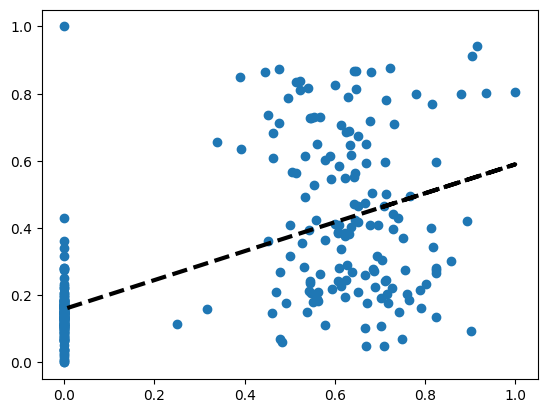

In [446]:
### 1-WL fingerprint similarity vs. (1-auc) similarity
onehot_sim_max = []
onehot_auc_sim_max = []
for row in range(len(onehot_sim)):
    tmp = np.triu(onehot_sim, k=1)[row]
    onehot_sim_max += [max(tmp)]*len(np.where(tmp == max(tmp))[0])
    onehot_auc_sim_max += list(auc_sim[row][np.where(tmp == max(tmp))[0]])
plt.scatter(onehot_sim_max, onehot_auc_sim_max)
#plt.plot([0, 1], [0, 1], 'k--', color = 'black')

from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(onehot_sim_max).reshape(-1,1), np.array(onehot_auc_sim_max)

#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/3193343254.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.4374601245782237

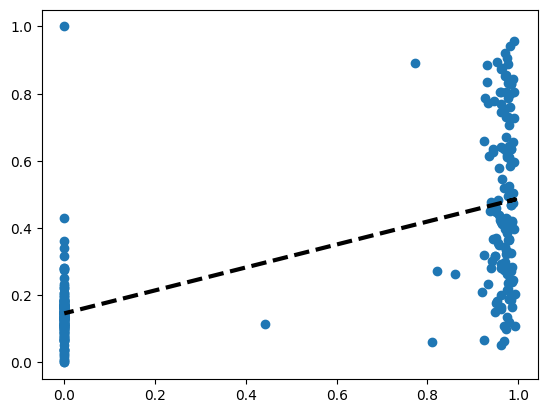

In [447]:
### 1-WL gnn similarity vs. (1-auc) similarity
gnn_sim_max = []
gnn_auc_sim_max = []
for row in range(len(gnn_sim)):
    tmp = np.triu(gnn_sim, k=1)[row]

    gnn_sim_max += [max(tmp)]*len(np.where(tmp == max(tmp))[0])
    gnn_auc_sim_max += list(auc_sim[row][np.where(tmp == max(tmp))[0]])

plt.scatter(gnn_sim_max, gnn_auc_sim_max)
#plt.plot([0, 1], [0, 1], 'k--', color = 'black')

from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(gnn_sim_max).reshape(-1,1), np.array(gnn_auc_sim_max)


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/3287652580.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


5.779312611553511e-05

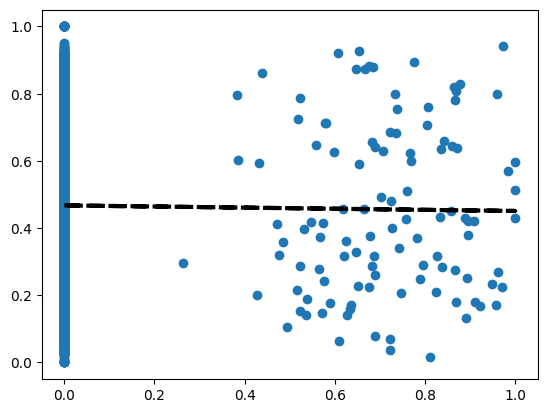

In [448]:
### Word2vec embeddings similarity vs. (1-auc) similarity
word2vec_sim_max = []
word2vec_auc_sim_max = []
for row in range(len(word2vec_sim)):
    tmp = np.triu(word2vec_sim, k=1)[row]
    word2vec_sim_max += [max(tmp)]*len(np.where(tmp == max(tmp))[0])
    word2vec_auc_sim_max += list(auc_sim[row][np.where(tmp == max(tmp))[0]])

plt.scatter(word2vec_sim_max, word2vec_auc_sim_max)
#plt.plot([0, 1], [0, 1], 'k--', color = 'black')

from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(word2vec_sim_max).reshape(-1,1), np.array(word2vec_auc_sim_max)


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/2181829899.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.4136238544794445

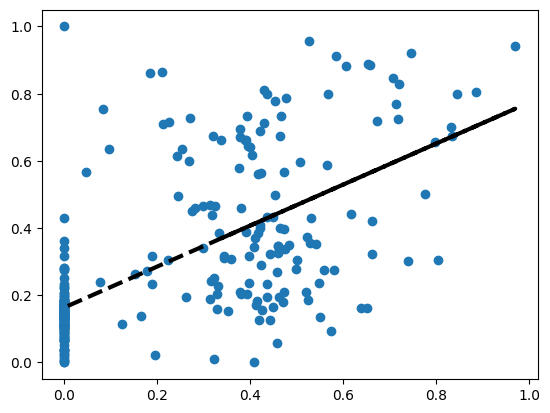

In [449]:
### RDKit Daylight-like fingerprint similarity vs. (1-auc) similarity
mol_sim_max = []
mol_auc_sim_max = []
for row in range(len(mol_sim)):
    tmp = np.triu(mol_sim, k=1)[row]
    mol_sim_max += [max(tmp)]*len(np.where(tmp == max(tmp))[0])
    mol_auc_sim_max += list(auc_sim[row][np.where(tmp == max(tmp))[0]])

plt.scatter(mol_sim_max, mol_auc_sim_max)
#plt.plot([0, 1], [0, 1], 'k--', color = 'black')

from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(mol_sim_max).reshape(-1,1), np.array(mol_auc_sim_max)


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

In [450]:
#1-4.zero proportion analysis
## import prediction and ground truth
svm_RDKfp_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/svm_RDKfp_DrugBlind_pred.csv", index_col = 'drug')
SMILESVec_pred = pd.read_csv("/volume/yihyun/drug/SMILESVec_model/SMILESVec_multi_out_pred.csv", index_col = 'smiles')
WLgnn_pred = pd.read_csv("/volume/yihyun/drug/baseline_model/moleculargnn_smiles_pred.csv", index_col = 'smiles')
MF_pred = pd.read_csv("/volume/yihyun/drug/MF_model/CaDRReS_DrugSim_pred.csv", index_col = 0)
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_drugBlind_test.csv", index_col = 'smiles')
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')

mask = np.matrix(np.isnan(prism_test)==False, dtype=int).T
label = np.matrix(prism_test).T
pred_svm_RDKfp = np.matrix(svm_RDKfp_pred).T
pred_SMILEVec = np.matrix(SMILESVec_pred).T
pred_WLgnn = np.matrix(WLgnn_pred).T
pred_MF = np.matrix(MF_pred).T

test_cl_res_mat  = np.empty((452,5,))
test_cl_res_mat[:] = np.nan
test_res_cl_mat_df = pd.DataFrame(test_cl_res_mat, 
                                  index = prism_train.columns.tolist(),
                                  columns=["zero_proportion",
                                            "svm_RDKfp_PCC", "SMILESVec_PCC",
                                            "1-WLgnn_PCC", "MF_PCC"])

test_res_cl_mat_df["svm_RDKfp_PCC"] = masked_aCC(pred_svm_RDKfp, label, mask)
test_res_cl_mat_df["SMILESVec_PCC"] = masked_aCC(pred_SMILEVec, label, mask)
test_res_cl_mat_df["1-WLgnn_PCC"] = masked_aCC(pred_WLgnn, label, mask)
test_res_cl_mat_df["MF_PCC"] = masked_aCC(pred_MF, label, mask)


for cell_line in prism_train.columns.tolist():
    train_mol = prism_train[cell_line].dropna().index.tolist()
    
    test_res_cl_mat_df.loc[cell_line]["zero_proportion"] = sum((prism_train.loc[train_mol,cell_line] == 0).astype(float))/len(train_mol)
test_res_cl_mat_df

,zero_proportion,svm_RDKfp_PCC,SMILESVec_PCC,1-WLgnn_PCC,MF_PCC
ACH-000090,0.357621,0.447685,0.296175,0.292560,0.352554
ACH-000592,0.431138,0.406652,0.134773,0.379153,0.439472
ACH-000696,0.384800,0.471205,0.303910,0.282441,0.394571
ACH-000467,0.359601,0.423704,0.321036,0.347220,0.440718
ACH-000261,0.292639,0.455300,0.271063,0.331009,0.395143
...,...,...,...,...,...
ACH-000765,0.418776,0.526360,0.293770,0.407841,0.432454
ACH-000404,0.511130,0.496701,0.231013,0.415282,0.402374
ACH-000232,0.352941,0.520743,0.268654,0.287015,0.383405
ACH-000182,0.423743,0.447038,0.291313,0.243495,0.360197


/tmp/ipykernel_321912/421869249.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.038214673810511024

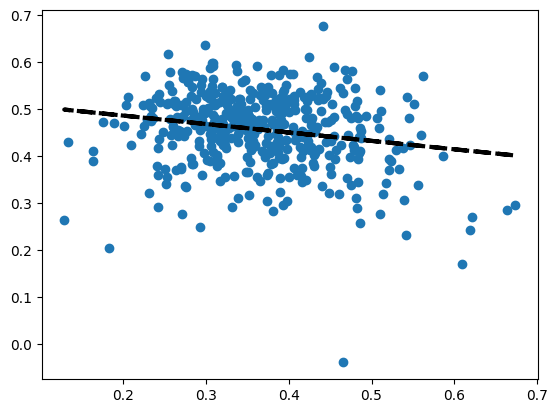

In [451]:
plt.scatter(test_res_cl_mat_df["zero_proportion"], test_res_cl_mat_df["svm_RDKfp_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["zero_proportion"]).reshape(-1, 1), np.array(test_res_cl_mat_df["svm_RDKfp_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/801675794.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.0663658146982884

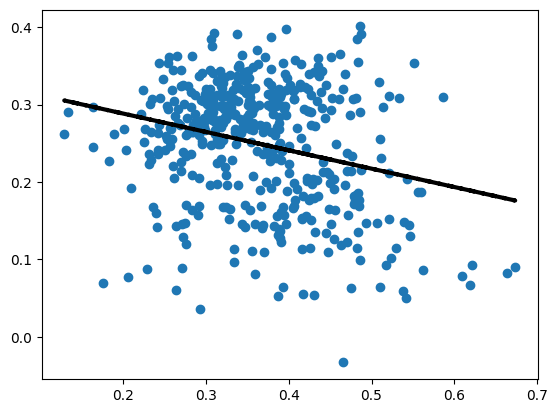

In [452]:
plt.scatter(test_res_cl_mat_df["zero_proportion"], test_res_cl_mat_df["SMILESVec_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["zero_proportion"]).reshape(-1, 1), np.array(test_res_cl_mat_df["SMILESVec_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/1217765826.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.009199812521297868

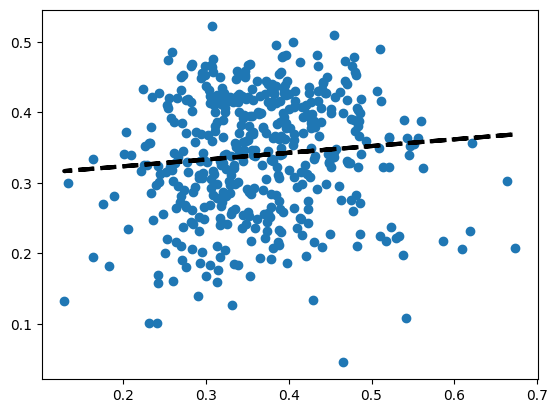

In [453]:
plt.scatter(test_res_cl_mat_df["zero_proportion"], test_res_cl_mat_df["1-WLgnn_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["zero_proportion"]).reshape(-1, 1), np.array(test_res_cl_mat_df["1-WLgnn_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/1290077590.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.01700059994978964

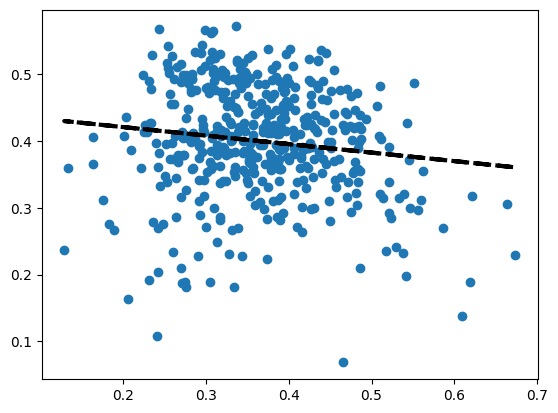

In [454]:
plt.scatter(test_res_cl_mat_df["zero_proportion"], test_res_cl_mat_df["MF_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["zero_proportion"]).reshape(-1, 1), np.array(test_res_cl_mat_df["MF_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

In [455]:
#1-5. missing data per cell line vs. pcc
## import prediction and ground truth
svm_RDKfp_pred = pd.read_csv("/volume/yihyun/drug/traditional_ML_model/svm_RDKfp_DrugBlind_pred.csv", index_col = 'drug')
SMILESVec_pred = pd.read_csv("/volume/yihyun/drug/SMILESVec_model/SMILESVec_multi_out_pred.csv", index_col = 'smiles')
WLgnn_pred = pd.read_csv("/volume/yihyun/drug/baseline_model/moleculargnn_smiles_pred.csv", index_col = 'smiles')
MF_pred = pd.read_csv("/volume/yihyun/drug/MF_model/CaDRReS_DrugSim_pred.csv", index_col = 0)
prism_test = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_drugBlind_test.csv", index_col = 'smiles')
prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')

mask = np.matrix(np.isnan(prism_test)==False, dtype=int).T
train_mask = np.matrix(np.isnan(prism_train)==True, dtype=int).T
label = np.matrix(prism_test).T
pred_svm_RDKfp = np.matrix(svm_RDKfp_pred).T
pred_SMILEVec = np.matrix(SMILESVec_pred).T
pred_WLgnn = np.matrix(WLgnn_pred).T
pred_MF = np.matrix(MF_pred).T

test_cl_res_mat  = np.empty((452,5,))
test_cl_res_mat[:] = np.nan
test_res_cl_mat_df = pd.DataFrame(test_cl_res_mat, 
                                  index = prism_test.columns.tolist(),
                                  columns=["missing_%",
                                            "svm_RDKfp_PCC", "SMILESVec_PCC",
                                            "1-WLgnn_PCC", "MF_PCC"])

test_res_cl_mat_df["missing_%"] = np.array(np.sum(train_mask, 1)/1297).flatten()
test_res_cl_mat_df["svm_RDKfp_PCC"] = masked_aCC(pred_svm_RDKfp, label, mask)
test_res_cl_mat_df["SMILESVec_PCC"] = masked_aCC(pred_SMILEVec, label, mask)
test_res_cl_mat_df["1-WLgnn_PCC"] = masked_aCC(pred_WLgnn, label, mask)
test_res_cl_mat_df["MF_PCC"] = masked_aCC(pred_MF, label, mask)
test_res_cl_mat_df

,missing_%,svm_RDKfp_PCC,SMILESVec_PCC,1-WLgnn_PCC,MF_PCC
ACH-000090,0.079414,0.447685,0.296175,0.292560,0.352554
ACH-000592,0.098689,0.406652,0.134773,0.379153,0.439472
ACH-000696,0.036237,0.471205,0.303910,0.282441,0.394571
ACH-000467,0.148805,0.423704,0.321036,0.347220,0.440718
ACH-000261,0.141095,0.455300,0.271063,0.331009,0.395143
...,...,...,...,...,...
ACH-000765,0.055513,0.526360,0.293770,0.407841,0.432454
ACH-000404,0.099460,0.496701,0.231013,0.415282,0.402374
ACH-000232,0.134927,0.520743,0.268654,0.287015,0.383405
ACH-000182,0.064765,0.447038,0.291313,0.243495,0.360197


/tmp/ipykernel_321912/3353814145.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.02275148776935476

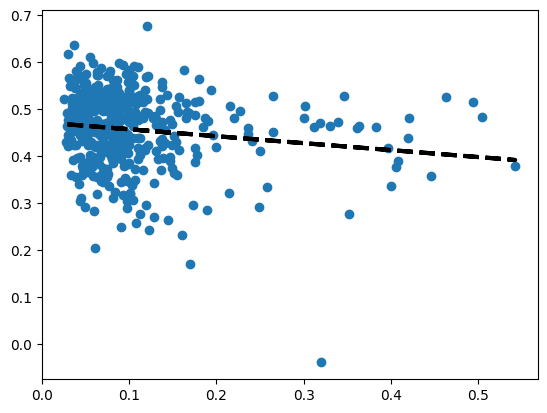

In [456]:
plt.scatter(test_res_cl_mat_df["missing_%"], test_res_cl_mat_df["svm_RDKfp_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["missing_%"]).reshape(-1, 1), np.array(test_res_cl_mat_df["svm_RDKfp_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/985151604.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.12428757908794075

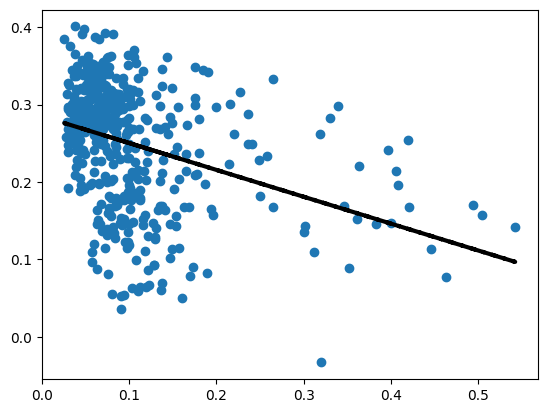

In [457]:
plt.scatter(test_res_cl_mat_df["missing_%"], test_res_cl_mat_df["SMILESVec_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["missing_%"]).reshape(-1, 1), np.array(test_res_cl_mat_df["SMILESVec_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/3778023071.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.13811908536752304

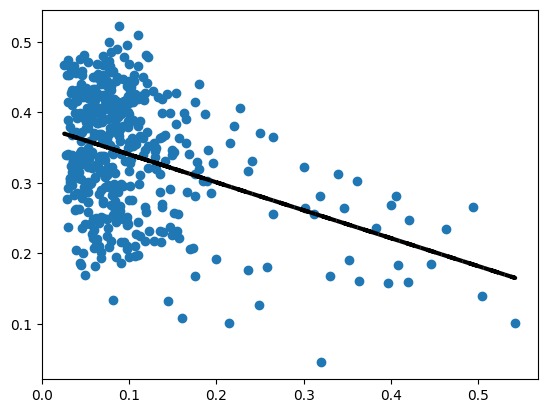

In [458]:
plt.scatter(test_res_cl_mat_df["missing_%"], test_res_cl_mat_df["1-WLgnn_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["missing_%"]).reshape(-1, 1), np.array(test_res_cl_mat_df["1-WLgnn_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)

/tmp/ipykernel_321912/2206010251.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X, y_pred, 'k--', color="black", linewidth=3)


0.3072520465324142

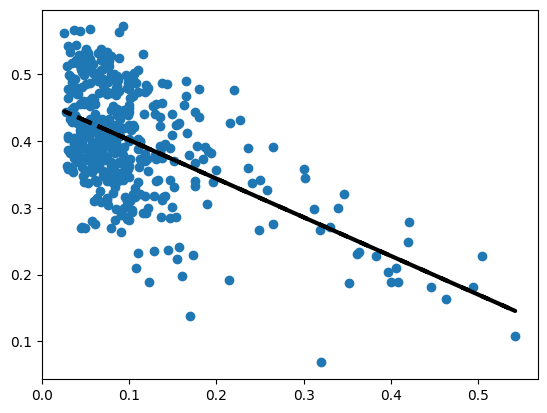

In [459]:
plt.scatter(test_res_cl_mat_df["missing_%"], test_res_cl_mat_df["MF_PCC"])
from sklearn.linear_model import LinearRegression 
#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = np.array(test_res_cl_mat_df["missing_%"]).reshape(-1, 1), np.array(test_res_cl_mat_df["MF_PCC"])


#fit regression model
model.fit(X, y)

y_pred = model.predict(X)
plt.plot(X, y_pred, 'k--', color="black", linewidth=3)
model.score(X, y)